<img src="./Data/公式.png" style="zoom:50%;" />

# Import

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=30caedd6e3d2c6b2314292e4a418f862e14f74f506a99277fa0c44a24f80b7f8
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [2]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras
import time

tf.random.set_seed(1234)
np.random.seed(1234)

# Setting

In [3]:

x = symbols('x')
y = symbols('y')
t = symbols('t')

a = v1 = v2 = k =1 #a=4 ,v1=5,v2=10,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*(1-x)*(1-y)*exp(-t)
u2 = a*x*(1-x)*(c1 + c2*y + c3*y**2)*exp(-t)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2))

u1 = lambdify((x,y,t),u1)
u2 = lambdify((x,y,t),u2)

f1 = lambdify((x,y,t),f1,'tensorflow')
f2 = lambdify((x,y,t),f2,'tensorflow')

# TrainingData & TestData

In [4]:
def trainingdata(N_u,N_f,N_i,omga,u,interface):    
    '''
      x1 = x,  x2 = y
      interface = 0, 则x2_range[0] 作为 interface ； interfacer = 1 则 x2_range[1]作为interface
    
      Return: X_u_train (N_u x 3),u_train (N_u x 1), X_f_train (N_f x 3), X_i_train (N_i x 3)
    '''
    x1_range = omga[0]
    x2_range = omga[1]
    t_range = [0.,1.]
    
    # Initial Condition t=0 , x1_range[0]<= x1 <= x_range[1] , x2_range[0] <= x2 <= x2_range[1]
    initial_X = np.ones((N_u,3))
    initial_X[:,0] = np.random.rand(N_u) * (x1_range[1] - x1_range[0]) + x1_range[0]
    initial_X[:,1] = np.random.rand(N_u) * (x2_range[1] - x2_range[0]) + x2_range[0]
    initial_X[:,2] = initial_X[:,2] * t_range[0]
    #initial_u = np.ones((N_u,1))
    initial_u = u(initial_X[:,0], initial_X[:,1], initial_X[:,2])
    initial_u = initial_u.reshape(-1,1)


    # BC_left: x1=x1_range[0], 0<=t<=1, x2_range[0] <= x2 <= x2_range[1]
    leftedge_X = np.ones(shape=(N_u,3))
    leftedge_X[:,0] = leftedge_X[:,0] * x1_range[0]
    leftedge_X[:,1] = np.random.rand(N_u) * (x2_range[1] - x2_range[0]) + x2_range[0]
    leftedge_X[:,2] = np.random.rand(N_u) * (t_range[1] - t_range[0]) + t_range[0]
    leftedge_u = np.ones(shape=(N_u,1))
    leftedge_u = u(leftedge_X[:,0], leftedge_X[:,1], leftedge_X[:,2])
    leftedge_u = leftedge_u.reshape(-1,1)
    
    # BC_right: x1=x1_range[1], 0<=t<=1, x2_range[0] <= x2 <= x2_range[1]
    rightedge_X = np.ones(shape=(N_u,3))
    rightedge_X[:,0] = rightedge_X[:,0] * x1_range[1]
    rightedge_X[:,1] = np.random.rand(N_u) * (x2_range[1] - x2_range[0]) + x2_range[0]
    rightedge_X[:,2] = np.random.rand(N_u) * (t_range[1] - t_range[0]) + t_range[0]
    rightedge_u = np.ones(shape=(N_u,1))
    rightedge_u = u(rightedge_X[:,0], rightedge_X[:,1], rightedge_X[:,2])
    rightedge_u = rightedge_u.reshape(-1,1)

    # BC_top or BC_bottom ,depends on interface. x2 = x2_range[bc], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    bc = (interface+1)%2
    BC_X = np.ones(shape=(N_u,3))
    BC_X[:,0] = np.random.rand(N_u) * (x1_range[1] - x1_range[0]) + x1_range[0]
    BC_X[:,1] = BC_X[:,1] * x2_range[bc]
    BC_X[:,2] = np.random.rand(N_u) * (t_range[1] - t_range[0]) + t_range[0]
    BC_u = np.ones(shape=(N_u,1))
    BC_u = u(BC_X[:,0], BC_X[:,1], BC_X[:,2])
    BC_u = BC_u.reshape(-1,1)
    
    all_X_u_train =  np.vstack([initial_X,leftedge_X,rightedge_X,BC_X])
    all_u_train = np.vstack([initial_u,leftedge_u,rightedge_u,BC_u])
    
    idx = np.random.choice(all_X_u_train.shape[0],all_X_u_train.shape[0], replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
    
    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    X_i_train = np.ones(shape=(N_i,3))
    X_i_train[:,0] = np.random.rand(N_i) * (x1_range[1] - x1_range[0]) + x1_range[0]
    X_i_train[:,1] = X_i_train[:,1] * x2_range[interface]
    X_i_train[:,2] = np.random.rand(N_i) * (t_range[1] - t_range[0]) + t_range[0]     
            
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x1,x2,t)
    lb = np.array([x1_range[0],x2_range[0],t_range[0]])
    ub = np.array([x1_range[1],x2_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    #X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_u_train,u_train,X_f_train,X_i_train

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds

In [5]:
omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 
def test_data(N,omga,u,t=1.):
  # Output: X,Y,T,U shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  y_range = tf.linspace(omga[1][0],omga[1][1],N)

  X,Y = tf.meshgrid(x_range,y_range)
  T = tf.ones(shape=X.shape)*t
  U = u(X,Y,T)
  return X,Y,T,U

def pred_data(X,Y,T,model):
  #Input: X,Y,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  Y = tf.reshape(Y,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,Y,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred


# PINN Model

In [6]:
class MyPinn(keras.Sequential): 
    def __init__(self,Layers,v,n,k,f,name = None): #Layers=[3,20,20,1]
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64, activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))
        self.v = tf.constant(v,dtype=tf.float64)
        self.n = tf.constant(n,dtype=tf.float64)
        self.k = tf.constant(k,dtype=tf.float64)
        self.f = f
        
    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
    #   
    @tf.function
    def loss_PDE(self,X_f_train):
        x = X_f_train[:,0:1]
        y = X_f_train[:,1:2]
        t = X_f_train[:,2:3]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x,y,t])
            X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
            u = self(X)  
            u_x = tape.gradient(u,x)
            u_y = tape.gradient(u,y)
            #u_t = tape.gradient(u,t)
        #tf.print(u_x)    
        u_t = tape.gradient(u, t)     
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)

        del tape
      
        loss_f = u_t - self.v *(u_xx + u_yy) - self.f(x,y,t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f
    """以下为单区域PINN 训练方法"""    
    @tf.function
    def train_loop(self,X_u_train,u_train,X_f_train):
      with tf.GradientTape() as tape:
        loss = self.loss_U(X_u_train,u_train) + self.loss_PDE(X_f_train)
      gradients = tape.gradient(loss,self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

      return loss

    def train(self,X_u_train,u_train,X_f_train,epochs=200):
      for epoch in tf.range(1,epochs+1):
          loss = self.train_loop(X_u_train,u_train,X_f_train)
          if epoch % 50 == 0:                
              tf.print(
                  "Training loss (for per 10 epoches) at epoch ",epoch,":",loss
              )

In [45]:
class CouplePinn(keras.Model):
  def __init__(self,model_1,model_2,name=None):
    super(CouplePinn,self).__init__(name=name)
    self.m1 = model_1 
    self.m2 = model_2
    
    # Metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.loss_adaptive = keras.metrics.Mean(name="loss_adaptive")
    self.loss_u1 = keras.metrics.Mean(name="loss_u1")
    self.loss_u2 = keras.metrics.Mean(name="loss_u2")
    self.loss_i = keras.metrics.Mean(name="loss_i")

    # Self-Adaptive factors     
    self.alpha1 = tf.Variable(0.0, dtype = tf.float64, trainable = True)     
    self.alpha2 = tf.Variable(0.0, dtype = tf.float64, trainable = True)
    #self.alpha_i = tf.Variable(1.0, dtype = tf.float64, trainable = True)

    self.optimizer_alpha = keras.optimizers.Adam(learning_rate=0.05)
    #self.optimizer_alpha_m2 = keras.optimizers.Adam(learning_rate=0.001)
    #self.optimizer_alpha_i = keras.optimizers.Adam(learning_rate=0.001)
  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      return [self.loss_adaptive,self.loss_tracker,self.loss_u1,self.loss_u2,self.loss_i] 


  """ 交界处损失函数 """
  @tf.function
  def loss_I(self,X_i_train):
      x = X_i_train[:,0:1]
      y = X_i_train[:,1:2]
      t = X_i_train[:,2:3]
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,y,t])
          X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
          U1 = self.m1(X)
          U2 = self.m2(X)
      
      U1_x = tape.gradient(U1, x)
      U1_y = tape.gradient(U1, y)
      U2_x = tape.gradient(U2, x)
      U2_y = tape.gradient(U2, y)

      del tape
      
      loss_i1 = -self.m1.v * ( U1_x*self.m1.n[0] + U1_y*self.m1.n[1]) - self.m1.k * (U1-U2)
      loss_i2 = -self.m2.v * ( U2_x*self.m2.n[0] + U2_y*self.m2.n[1]) - self.m2.k * (U2-U1)

      loss_i1 = tf.reduce_mean(tf.square(loss_i1)) 
      loss_i2 = tf.reduce_mean(tf.square(loss_i2))

      return loss_i1,loss_i2

  """耦合区域 PINN训练方法"""
  @tf.function
  def train_step(self,data):
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_m1 = self.m1.loss_U(X_u1_train,u1_train) + self.m1.loss_PDE(X_f1_train)
          loss_m2 = self.m2.loss_U(X_u2_train,u2_train) + self.m2.loss_PDE(X_f2_train)
          loss_i1,loss_i2 = self.loss_I(X_i_train)

          a1 = tf.math.sigmoid(2*self.alpha1+0.5) * 2
          a2 = tf.math.sigmoid(2*self.alpha2+0.5) * 2
          loss_adaptive = a1*(loss_m1+loss_i1) + a2*(loss_m2+loss_i2)
          #loss_adaptive = (loss_m1+loss_i1) + (loss_m2+loss_i2)

      loss = loss_m1 + loss_m2 + loss_i1 + loss_i2
      # Compute gradients
      gradients_m1 = tape.gradient(loss_adaptive,self.m1.trainable_variables)
      gradients_m2 = tape.gradient(loss_adaptive,self.m2.trainable_variables)
      gradient_a1pha1 = -tape.gradient(loss_adaptive,self.alpha1)
      gradient_alpha2 = -tape.gradient(loss_adaptive,self.alpha2)

      del tape

      # Updata parameters
      self.m1.optimizer.apply_gradients(zip(gradients_m1, self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_m2, self.m2.trainable_variables))
      self.optimizer_alpha.apply_gradients( zip([gradient_a1pha1,gradient_alpha2], [self.alpha1,self.alpha2]) )

      # Updata Metric
      self.loss_adaptive.update_state(loss_adaptive)
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_m1+loss_i1)
      self.loss_u2.update_state(loss_m2+loss_i2)
      self.loss_i.update_state(loss_i1+loss_i2)

      return {m.name : m.result() for m in self.metrics}
  

# Train

In [39]:
""" Training Data """
n1 = [0.,-1.]
n2 = [0.,1.]

omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 

N_i = 500

N_u1 = 500; N_f1 = 2000  ;omga = omga1; interface=0; u = u1
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_f1,N_i,omga,u,interface)


N_u2 = 500; N_f2= 2000 ; omga = omga2; interface=1; u = u2
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_f2,N_i,omga,u,interface)

""" Test Data """
N = 100
X_u1,Y_u1,T_u1,U1 = test_data(N,omga1,u1,t=1.0)
X_u2,Y_u2,T_u2,U2 = test_data(N,omga2,u2,t=1.0)

In [40]:
Layers=[3,20,20,20,20,1]
model_u1 = MyPinn(Layers,v1,n1,k,f1,name="model_1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = MyPinn(Layers,v2,n2,k,f2,name="model_2")
model_u2.compile(optimizer=keras.optimizers.Adam())

ds = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 10)

In [41]:
model_u1.train(X_u1_train,u1_train,X_f1_train,epochs=1000) #单区域PINN训练
model_u2.train(X_u2_train,u2_train,X_f2_train,epochs=1000) #单区域PINN训练

Training loss (for per 10 epoches) at epoch  50 : 0.070458691426636383
Training loss (for per 10 epoches) at epoch  100 : 0.018384293301757369
Training loss (for per 10 epoches) at epoch  150 : 0.011014140265853005
Training loss (for per 10 epoches) at epoch  200 : 0.0076205891753122357
Training loss (for per 10 epoches) at epoch  250 : 0.00618301486962335
Training loss (for per 10 epoches) at epoch  300 : 0.0054422806822153683
Training loss (for per 10 epoches) at epoch  350 : 0.0049843474182736051
Training loss (for per 10 epoches) at epoch  400 : 0.004667479812109152
Training loss (for per 10 epoches) at epoch  450 : 0.0044293736072210472
Training loss (for per 10 epoches) at epoch  500 : 0.00424028704852069
Training loss (for per 10 epoches) at epoch  550 : 0.0040840545481560528
Training loss (for per 10 epoches) at epoch  600 : 0.0039505364245247193
Training loss (for per 10 epoches) at epoch  650 : 0.0038328101819370547
Training loss (for per 10 epoches) at epoch  700 : 0.0037260

In [46]:
couple_model = CouplePinn(model_u1,model_u2) 
couple_model.compile()

In [47]:
couple_model.fit(ds,epochs=1500)#耦合PINN训练

10/10 [==============================] - 0s 33ms/step - loss_adaptive: 0.0094 - loss: 0.0047 - loss_u1: 0.0010 - loss_u2: 0.0037 - loss_i: 3.5515e-04
Epoch 160/1500
10/10 [==============================] - 0s 31ms/step - loss_adaptive: 0.0093 - loss: 0.0047 - loss_u1: 0.0010 - loss_u2: 0.0036 - loss_i: 3.5406e-04
Epoch 161/1500
10/10 [==============================] - 0s 31ms/step - loss_adaptive: 0.0093 - loss: 0.0047 - loss_u1: 0.0010 - loss_u2: 0.0036 - loss_i: 3.5305e-04
Epoch 162/1500
10/10 [==============================] - 0s 31ms/step - loss_adaptive: 0.0092 - loss: 0.0046 - loss_u1: 0.0010 - loss_u2: 0.0036 - loss_i: 3.5210e-04
Epoch 163/1500
10/10 [==============================] - 0s 31ms/step - loss_adaptive: 0.0092 - loss: 0.0046 - loss_u1: 0.0010 - loss_u2: 0.0036 - loss_i: 3.5122e-04
Epoch 164/1500
10/10 [==============================] - 0s 32ms/step - loss_adaptive: 0.0092 - loss: 0.0046 - loss_u1: 0.0010 - loss_u2: 0.0036 - loss_i: 3.5040e-04
Epoch 165/1500
10/10 [===

In [16]:
couple_model.alpha1

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.648054978937277>

In [ ]:
'''
u1_i = u1(X_i_train[:,0],X_i_train[:,1],X_i_train[:,2])
u2_i = u2(X_i_train[:,0],X_i_train[:,1],X_i_train[:,2])
u1_i = u1_i.reshape((u1_i.shape[0],1))
u2_i = u1_i.reshape((u2_i.shape[0],1))

X_u1_train_ = tf.concat([X_u1_train,X_i_train],axis=0)
X_u2_train_ = tf.concat([X_u2_train,X_i_train],axis=0)
u1_train_ = tf.concat([u1_train,u1_i],axis=0)
u2_train_ = tf.concat([u2_train,u2_i],axis=0) 
'''

In [ ]:
"""history_u1 = model_u1.fit(
    X_u1_train,
    u1_train,
    batch_size=64,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    #validation_data=(x_val, y_val),
)
history_u2 = model_u2.fit(
    X_u2_train,
    u2_train,
    batch_size=64,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    #validation_data=(x_val, y_val),
)"""

# Plot

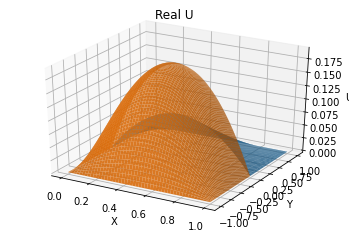

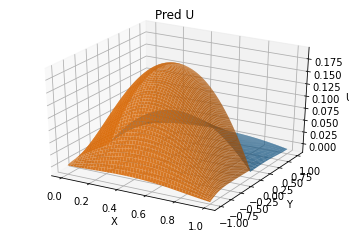

In [48]:
U1_pred = pred_data(X_u1,Y_u1,T_u1,model_u1)
U2_pred = pred_data(X_u2,Y_u2,T_u2,model_u2)
####################################################
plt.figure(1) 
ax1 = plt.axes(projection="3d")
ax1.patch.set_facecolor("white")   #设置 axes 背景颜色

ax1.plot_surface(X_u1,Y_u1,U1,alpha=0.9) #生成曲面z，alpha调节透明度，cmap调节曲面色调
ax1.plot_surface(X_u2,Y_u2,U2,alpha=0.9)

ax1.set_xlabel("X")   
ax1.set_ylabel("Y")
ax1.set_zlabel("U")
ax1.set_title("Real U")
######################################################
plt.figure(2) 
ax2 = plt.axes(projection="3d")
ax2.patch.set_facecolor("white") 

### u1
ax2.plot_surface(X_u1,Y_u1,U1_pred,alpha=0.9)

###u2
ax2.plot_surface(X_u2,Y_u2,U2_pred,alpha=0.9)

ax2.set_xlabel("X")   
ax2.set_ylabel("Y")
ax2.set_zlabel("U")
ax2.set_title("Pred U")
###############################
plt.show()

In [49]:
u1_real = U1.numpy().flatten()
u1_pred = U1_pred.numpy().flatten()
u2_real = U2.numpy().flatten()
u2_pred = U2_pred.numpy().flatten()

error_u1 = np.linalg.norm((u1_real-u1_pred),2)/np.linalg.norm(u1_real,2)  
print('Test Error For u1:  %.5f'  % (error_u1))

error_u2 = np.linalg.norm((u2_real-u2_pred),2)/np.linalg.norm(u2_real,2)  
print('Test Error For u2:  %.5f'  % (error_u2))

Test Error For u1:  0.06296
Test Error For u2:  0.02420
